In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.chdir('../')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tcav
from src.download_data import download_imagenet, download_random_imagenet_classes

In [4]:
concepts_wanted = ["German shepherd","bulldog","Komodo dragon","Gila monster",
                   "cardinal","woodpecker","sweater","three-piece suit","school","house"]

In [7]:
download_imagenet(concepts_wanted,50)

INFO:tensorflow:Downloading imagenet_classes ['German shepherd', 'bulldog', 'Komodo dragon', 'Gila monster', 'cardinal', 'woodpecker', 'sweater', 'three-piece suit', 'school', 'house']
INFO:tensorflow:Downloading class German shepherd
INFO:tensorflow:Fetching imagenet data for German shepherd
INFO:tensorflow:Saving images at ./dataset/images/german_shepherd
INFO:tensorflow:Downloaded 50 images for German shepherd
INFO:tensorflow:Downloading class bulldog
INFO:tensorflow:Fetching imagenet data for bulldog
INFO:tensorflow:Saving images at ./dataset/images/bulldog
INFO:tensorflow:Downloaded 50 images for bulldog
INFO:tensorflow:Downloading class Komodo dragon
INFO:tensorflow:Fetching imagenet data for Komodo dragon
INFO:tensorflow:Saving images at ./dataset/images/komodo_dragon
INFO:tensorflow:Downloaded 50 images for Komodo dragon
INFO:tensorflow:Downloading class Gila monster
INFO:tensorflow:Fetching imagenet data for Gila monster
INFO:tensorflow:Saving images at ./dataset/images/gila_m

In [10]:
download_random_imagenet_classes(20,50)

INFO:tensorflow:Downloading 20 random ImageNet classes
INFO:tensorflow:Downloading class Boston fern
INFO:tensorflow:Fetching imagenet data for Boston fern
INFO:tensorflow:Saving images at ./dataset/images/random500_0
INFO:tensorflow:Downloaded 50 images for Boston fern
INFO:tensorflow:Downloading class record player
INFO:tensorflow:Fetching imagenet data for record player
INFO:tensorflow:Saving images at ./dataset/images/random500_1
INFO:tensorflow:Downloaded 50 images for record player
INFO:tensorflow:Downloading class Easter egg
INFO:tensorflow:Fetching imagenet data for Easter egg
INFO:tensorflow:Saving images at ./dataset/images/random500_2
INFO:tensorflow:Downloaded 50 images for Easter egg
INFO:tensorflow:Downloading class autoinjector
INFO:tensorflow:Fetching imagenet data for autoinjector
INFO:tensorflow:Saving images at ./dataset/images/random500_3
INFO:tensorflow:Downloaded 50 images for autoinjector
INFO:tensorflow:Downloading class Texas bluebonnet
INFO:tensorflow:Fetching

# Plotting the dimensionality reduced data

In [2]:
def plot_tsne(data,colors): 
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)
        
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=colors)

In [3]:
def plot_PCA(data,colors): 
    X_embedded = PCA(n_components=2).fit_transform(data)
        
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=colors)

In [4]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
colors = ['r','r','b','b']

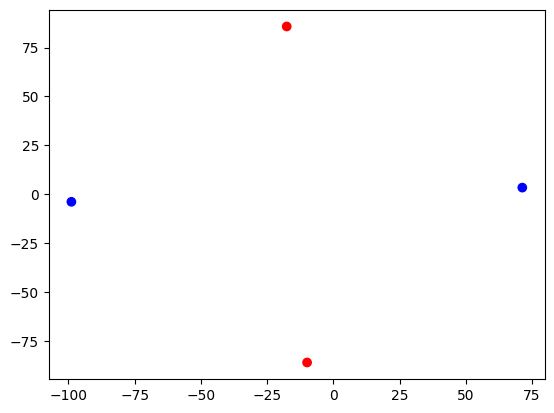

In [5]:
plot_tsne(X,colors)

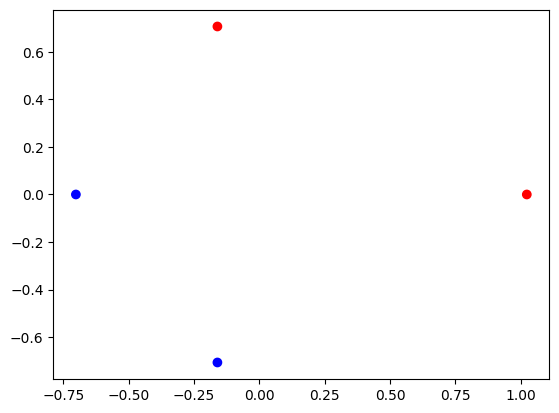

In [6]:
plot_PCA(X,colors)